In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving proje_klasoru.zip to proje_klasoru.zip


In [ ]:
import os, zipfile

ZIP_PATH = "/content/synth_ddpm_manip_2.zip"         # senin ürettiğin zip
EXTRACT_TO = "/content/synth_ddpm_manip_2"      # açılacağı yer

os.makedirs(EXTRACT_TO, exist_ok=True)

with zipfile.ZipFile(ZIP_PATH, "r") as zf:
    zf.extractall(EXTRACT_TO)

print("Extracted to:", EXTRACT_TO)
!find "{EXTRACT_TO}" -maxdepth 3 -type d -print


Extracted to: /content/synth_ddpm_manip_2
/content/synth_ddpm_manip_2
/content/synth_ddpm_manip_2/content
/content/synth_ddpm_manip_2/content/drive
/content/synth_ddpm_manip_2/content/drive/MyDrive


In [ ]:
import os
from glob import glob

EXTRACT_TO = "/content/synth_ddpm_manip_2"  # zip'i açtığın yer

# SENİN DEDİĞİN: zip içinde root'a böyle ulaşılıyor
ROOT = os.path.join(
    EXTRACT_TO,
    "/synth_ddpm_manip_2"
)

IMG_DIR = os.path.join(ROOT, "images")
DEN_DIR = os.path.join(ROOT, "density")
MSK_DIR = os.path.join(ROOT, "masks")
LBL_DIR = os.path.join(ROOT, "labels")

print("ROOT:", ROOT)
print("IMG_DIR exists:", os.path.isdir(IMG_DIR), "count:", len(glob(os.path.join(IMG_DIR,"*.png"))))
print("DEN_DIR exists:", os.path.isdir(DEN_DIR), "count:", len(glob(os.path.join(DEN_DIR,"*.png"))))
print("MSK_DIR exists:", os.path.isdir(MSK_DIR), "count:", len(glob(os.path.join(MSK_DIR,"*.png"))))
print("LBL_DIR exists:", os.path.isdir(LBL_DIR), "count:", len(glob(os.path.join(LBL_DIR,"*.txt"))))

assert os.path.isdir(IMG_DIR), "images klasörü bulunamadı -> ROOT path yanlış"


ROOT: /content/synth_ddpm_manip_2/content/drive/MyDrive/Medical Deep Fake/new_dataset/synth_ddpm_manip_2
IMG_DIR exists: True count: 10693
DEN_DIR exists: True count: 10693
MSK_DIR exists: True count: 10693
LBL_DIR exists: True count: 10693


In [ ]:
import json, random, time

SPLIT_JSON = os.path.join(ROOT, "split_fixed_density.json")

def list_ids():
    imgs = sorted(glob(os.path.join(IMG_DIR, "*.png")))
    return [os.path.splitext(os.path.basename(p))[0] for p in imgs]

def save_json(path, obj):
    with open(path, "w", encoding="utf-8") as f:
        json.dump(obj, f, indent=2)

def load_json(path):
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)

def build_or_load_fixed_splits(val_ratio=0.10, test_ratio=0.05):
    ids = list_ids()

    if os.path.exists(SPLIT_JSON):
        split = load_json(SPLIT_JSON)
        fixed_val = set(split["val"])
        fixed_test = set(split["test"])
        train = [i for i in ids if i not in (fixed_val | fixed_test)]
        val   = [i for i in ids if i in fixed_val]
        test  = [i for i in ids if i in fixed_test]
        return train, val, test

    ids_shuf = ids.copy()
    random.shuffle(ids_shuf)
    n = len(ids_shuf)
    n_test = max(1, int(n * test_ratio))
    n_val  = max(1, int(n * val_ratio))

    test = ids_shuf[:n_test]
    val  = ids_shuf[n_test:n_test+n_val]
    train = ids_shuf[n_test+n_val:]

    save_json(SPLIT_JSON, {"val": val, "test": test, "created_at": time.strftime("%F %T")})
    return train, val, test

train_ids, val_ids, test_ids = build_or_load_fixed_splits(0.10, 0.05)
print("Split sizes -> Train:", len(train_ids), "Val:", len(val_ids), "Test:", len(test_ids))
print("Split file:", SPLIT_JSON)


Split sizes -> Train: 9090 Val: 1069 Test: 534
Split file: /content/synth_ddpm_manip_2/content/drive/MyDrive/Medical Deep Fake/new_dataset/synth_ddpm_manip_2/split_fixed_density.json


In [ ]:
import cv2
import numpy as np

IMG_SIZE = 128

def read_gray_u8(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(path)
    if img.shape[:2] != (IMG_SIZE, IMG_SIZE):
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_AREA)
    return img.astype(np.uint8)

def read_den_f32(path):
    # density png: 0-255 -> 0-1 float
    den = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if den is None:
        # density yoksa sıfır döner
        return np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.float32)
    if den.shape[:2] != (IMG_SIZE, IMG_SIZE):
        den = cv2.resize(den, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_AREA)
    den = den.astype(np.float32) / 255.0
    return den

def read_mask01(path):
    m = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if m is None:
        return np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.float32)
    if m.shape[:2] != (IMG_SIZE, IMG_SIZE):
        m = cv2.resize(m, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
    return (m > 127).astype(np.float32)

def read_boxes_from_yolo(lbl_path):
    boxes=[]
    if not os.path.exists(lbl_path):
        return boxes
    with open(lbl_path, "r", encoding="utf-8") as f:
        for line in f:
            p = line.strip().split()
            if len(p) != 5:
                continue
            _, xc, yc, bw, bh = map(float, p)
            x1 = int((xc - bw/2) * IMG_SIZE)
            y1 = int((yc - bh/2) * IMG_SIZE)
            x2 = int((xc + bw/2) * IMG_SIZE)
            y2 = int((yc + bh/2) * IMG_SIZE)
            x1 = max(0, min(IMG_SIZE-1, x1)); y1 = max(0, min(IMG_SIZE-1, y1))
            x2 = max(0, min(IMG_SIZE-1, x2)); y2 = max(0, min(IMG_SIZE-1, y2))
            if x2 > x1 and y2 > y1:
                boxes.append((x1,y1,x2,y2))
    return boxes


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import functional as TF
import random

class ManipDensityDataset(Dataset):
    def __init__(self, ids, augment=False):
        self.ids = ids
        self.augment = augment

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        sid = self.ids[idx]
        img = read_gray_u8(os.path.join(IMG_DIR, f"{sid}.png"))
        den = read_den_f32(os.path.join(DEN_DIR, f"{sid}.png")) if os.path.isdir(DEN_DIR) else np.zeros((IMG_SIZE,IMG_SIZE),np.float32)
        msk = read_mask01(os.path.join(MSK_DIR, f"{sid}.png")) if os.path.isdir(MSK_DIR) else (den>0).astype(np.float32)
        boxes = read_boxes_from_yolo(os.path.join(LBL_DIR, f"{sid}.txt")) if os.path.isdir(LBL_DIR) else []

        img_t = torch.from_numpy(img).float().unsqueeze(0) / 255.0     # [1,H,W]
        den_t = torch.from_numpy(den).float().unsqueeze(0)             # [1,H,W] in [0,1]
        msk_t = torch.from_numpy(msk).float().unsqueeze(0)             # [1,H,W] in {0,1}

        # augmentation (flip) - density/mask ve boxes ile uyumlu
        if self.augment:
            if random.random() < 0.5:
                img_t = TF.hflip(img_t); den_t = TF.hflip(den_t); msk_t = TF.hflip(msk_t)
                boxes = [(IMG_SIZE-x2, y1, IMG_SIZE-x1, y2) for (x1,y1,x2,y2) in boxes]
            if random.random() < 0.3:
                img_t = TF.vflip(img_t); den_t = TF.vflip(den_t); msk_t = TF.vflip(msk_t)
                boxes = [(x1, IMG_SIZE-y2, x2, IMG_SIZE-y1) for (x1,y1,x2,y2) in boxes]

        return {"id": sid, "img": img_t, "den": den_t, "msk": msk_t, "boxes": boxes}

def collate_keep_boxes(batch):
    return {
        "id":   [b["id"] for b in batch],
        "img":  torch.stack([b["img"] for b in batch], 0),
        "den":  torch.stack([b["den"] for b in batch], 0),
        "msk":  torch.stack([b["msk"] for b in batch], 0),
        "boxes":[b["boxes"] for b in batch],
    }

BATCH = 16

train_ds = ManipDensityDataset(train_ids, augment=True)
val_ds   = ManipDensityDataset(val_ids,   augment=False)
test_ds  = ManipDensityDataset(test_ids,  augment=False)

train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True, num_workers=0, pin_memory=True, drop_last=True, collate_fn=collate_keep_boxes)
val_loader   = DataLoader(val_ds,   batch_size=BATCH, shuffle=False, num_workers=0, pin_memory=True,               collate_fn=collate_keep_boxes)
test_loader  = DataLoader(test_ds,  batch_size=BATCH, shuffle=False, num_workers=0, pin_memory=True,               collate_fn=collate_keep_boxes)

print(f"Loader sizes -> Train: {len(train_ds)} Val: {len(val_ds)} Test: {len(test_ds)} | iters/epoch: {len(train_loader)}")


Loader sizes -> Train: 9090 Val: 1069 Test: 534 | iters/epoch: 568


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class ConvBlock(nn.Module):
    def __init__(self, c_in, c_out):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(c_in, c_out, 3, padding=1),
            nn.BatchNorm2d(c_out),
            nn.ReLU(inplace=True),
            nn.Conv2d(c_out, c_out, 3, padding=1),
            nn.BatchNorm2d(c_out),
            nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.net(x)

class UNetDensity(nn.Module):
    def __init__(self):
        super().__init__()
        self.d1 = ConvBlock(1, 32)
        self.d2 = ConvBlock(32, 64)
        self.b  = ConvBlock(64, 128)
        self.u2 = ConvBlock(128+64, 64)
        self.u1 = ConvBlock(64+32, 32)

        self.den_head = nn.Conv2d(32, 1, 1)   # density (regression)
        self.msk_head = nn.Conv2d(32, 1, 1)   # mask logits (segmentation)

    def forward(self, x):
        d1 = self.d1(x)
        d2 = self.d2(F.max_pool2d(d1, 2))
        b  = self.b(F.max_pool2d(d2, 2))
        u2 = F.interpolate(b, scale_factor=2, mode="bilinear", align_corners=False)
        u2 = self.u2(torch.cat([u2, d2], 1))
        u1 = F.interpolate(u2, scale_factor=2, mode="bilinear", align_corners=False)
        u1 = self.u1(torch.cat([u1, d1], 1))

        pred_den = torch.sigmoid(self.den_head(u1))      # [0,1] density
        pred_msk_logit = self.msk_head(u1)               # logits
        return pred_den, pred_msk_logit


In [ ]:
def total_variation(x):
    # x: [B,1,H,W]
    return (x[:,:,1:,:]-x[:,:,:-1,:]).abs().mean() + (x[:,:,:,1:]-x[:,:,:,:-1]).abs().mean()

def compute_loss(pred_den, pred_msk_logit, gt_den, gt_msk, lam_msk=1.0, lam_tv=0.05):
    # density regression: robust
    loss_den = F.smooth_l1_loss(pred_den, gt_den)

    # mask supervision
    loss_msk = F.binary_cross_entropy_with_logits(pred_msk_logit, gt_msk)

    # smoothness on density
    loss_tv  = total_variation(pred_den)

    loss = loss_den + lam_msk*loss_msk + lam_tv*loss_tv
    return loss, {"den": float(loss_den.item()), "msk": float(loss_msk.item()), "tv": float(loss_tv.item())}


In [ ]:
import numpy as np
import cv2

def density_to_boxes(d01, thr=0.5, min_area=20):
    # d01: [H,W] float in [0,1]
    m = (d01 >= thr).astype(np.uint8)
    cnts,_ = cv2.findContours(m, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    boxes=[]
    for c in cnts:
        x,y,w,h = cv2.boundingRect(c)
        if w*h >= min_area:
            boxes.append((x,y,x+w,y+h))
    return boxes

def iou(a,b):
    x1=max(a[0],b[0]); y1=max(a[1],b[1])
    x2=min(a[2],b[2]); y2=min(a[3],b[3])
    inter=max(0,x2-x1)*max(0,y2-y1)
    A=(a[2]-a[0])*(a[3]-a[1])
    B=(b[2]-b[0])*(b[3]-b[1])
    return inter/(A+B-inter+1e-6)


In [ ]:
import torch

def eval_loader(model, loader, thr=0.5, min_area=20, iou_thr=0.5):
    model.eval()
    TP=FP=FN=0
    ious=[]
    abs_count_err=[]
    with torch.no_grad():
        for batch in loader:
            imgs = batch["img"].to(DEVICE, non_blocking=True)
            gt_boxes_list = batch["boxes"]

            pred_den, pred_msk_logit = model(imgs)
            pd = pred_den.detach().cpu().numpy()  # [B,1,H,W]

            for i in range(pd.shape[0]):
                d = pd[i,0]
                # normalize just in case
                d01 = d / (d.max() + 1e-8)

                pred_boxes = density_to_boxes(d01, thr=thr, min_area=min_area)
                gt_boxes = gt_boxes_list[i]

                # count error
                abs_count_err.append(abs(len(pred_boxes) - len(gt_boxes)))

                matched=set()
                for p in pred_boxes:
                    ok=False
                    best_iou=0.0
                    best_j=-1
                    for j,g in enumerate(gt_boxes):
                        if j in matched:
                            continue
                        v = iou(p,g)
                        if v > best_iou:
                            best_iou=v; best_j=j
                    if best_iou >= iou_thr:
                        TP += 1
                        matched.add(best_j)
                        ok=True
                        ious.append(best_iou)
                    if not ok:
                        FP += 1
                FN += (len(gt_boxes) - len(matched))

    prec = TP/(TP+FP+1e-6)
    rec  = TP/(TP+FN+1e-6)
    f1   = 2*prec*rec/(prec+rec+1e-6)

    # "mAP50 benzeri": iou_thr=0.5 sabitken precision raporu (tek nokta)
    map50_like = prec

    miou = float(np.mean(ious)) if len(ious)>0 else 0.0
    count_mae = float(np.mean(abs_count_err)) if len(abs_count_err)>0 else 0.0

    return {
        "Precision@0.5": float(prec),
        "Recall@0.5": float(rec),
        "F1@0.5": float(f1),
        "mAP50_like": float(map50_like),
        "mIoU_matched": miou,
        "Count_MAE": count_mae,
        "TP": int(TP), "FP": int(FP), "FN": int(FN),
    }


In [ ]:
import matplotlib.pyplot as plt

def draw_boxes(ax, boxes, color="lime", lw=2):
    for (x1,y1,x2,y2) in boxes:
        ax.add_patch(plt.Rectangle((x1,y1), x2-x1, y2-y1, fill=False, edgecolor=color, lw=lw))

def visualize_density_sample(sample, pred_den_map, pred_boxes, thr=0.25):
    img = sample["img"][0].numpy()
    gt_den = sample["den"][0].numpy()
    gt_boxes = sample["boxes"]

    pd = pred_den_map
    pd01 = pd / (pd.max() + 1e-8)
    gt01 = gt_den / (gt_den.max() + 1e-8) if gt_den.max() > 0 else gt_den

    fig, ax = plt.subplots(1, 4, figsize=(16,4))
    ax[0].imshow(img, cmap="gray"); ax[0].set_title("Image"); ax[0].axis("off")

    ax[1].imshow(gt01, cmap="hot"); ax[1].set_title("GT Density + GT Boxes"); ax[1].axis("off")
    draw_boxes(ax[1], gt_boxes, color="cyan")

    ax[2].imshow(pd01, cmap="hot"); ax[2].set_title(f"Pred Density (thr={thr})"); ax[2].axis("off")

    ax[3].imshow(img, cmap="gray"); ax[3].set_title("Pred Boxes on Image"); ax[3].axis("off")
    draw_boxes(ax[3], pred_boxes, color="lime")

    plt.show()


In [ ]:
from tqdm.auto import tqdm
import numpy as np
import torch

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNetDensity().to(DEVICE)
print("Device:", DEVICE)

EPOCHS = 100
LR = 1e-3
opt = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)

def get_random_val_sample():
    if len(val_ids) == 0:
        return None
    sid = random.choice(val_ids)
    ds = ManipDensityDataset([sid], augment=False)
    return ds[0]

THR = 0.25
MIN_AREA = 20

for epoch in range(1, EPOCHS+1):
    model.train()
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}")
    loss_sum = 0.0
    logs = {"den":0.0, "msk":0.0, "tv":0.0}
    n_batches = 0

    for batch in pbar:
        imgs = batch["img"].to(DEVICE, non_blocking=True)
        gt_den = batch["den"].to(DEVICE, non_blocking=True)
        gt_msk = batch["msk"].to(DEVICE, non_blocking=True)

        pred_den, pred_msk_logit = model(imgs)
        loss, parts = compute_loss(pred_den, pred_msk_logit, gt_den, gt_msk, lam_msk=1.0, lam_tv=0.05)

        opt.zero_grad()
        loss.backward()
        opt.step()

        loss_sum += loss.item()
        for k in logs:
            logs[k] += parts[k]
        n_batches += 1

        pbar.set_postfix(
            loss=loss_sum/max(1,n_batches),
            den=logs["den"]/max(1,n_batches),
            msk=logs["msk"]/max(1,n_batches),
            tv=logs["tv"]/max(1,n_batches),
        )

    # VAL metrics
    val_metrics = eval_loader(model, val_loader, thr=THR, min_area=MIN_AREA, iou_thr=0.5)
    print("\nVAL:", val_metrics)

    # random 1 val visualization
    sample = get_random_val_sample()
    if sample is not None:
        model.eval()
        with torch.no_grad():
            img_t = sample["img"].unsqueeze(0).to(DEVICE)
            pred_den, _ = model(img_t)
            pd = pred_den[0,0].detach().cpu().numpy()
            pd01 = pd / (pd.max() + 1e-8)
            pred_boxes = density_to_boxes(pd01, thr=THR, min_area=MIN_AREA)
        visualize_density_sample(sample, pd, pred_boxes, thr=THR)


In [ ]:
test_metrics = eval_loader(model, test_loader, thr=THR, min_area=MIN_AREA, iou_thr=0.28)
print("TEST:", test_metrics)

# 25 rastgele test görseli
model.eval()
for _ in range(25):
    sid = random.choice(test_ids)
    s = ManipDensityDataset([sid], augment=False)[0]
    with torch.no_grad():
        img_t = s["img"].unsqueeze(0).to(DEVICE)
        pred_den, _ = model(img_t)
        pd = pred_den[0,0].detach().cpu().numpy()
        pd01 = pd / (pd.max() + 1e-8)
        pb = density_to_boxes(pd01, thr=THR, min_area=MIN_AREA)
    visualize_density_sample(s, pd, pb, thr=THR)


BEST VAL (presence): {'thr': 0.28, 'score_mode': 'den_max', 'Accuracy': 0.993451824133776, 'Precision': 0.9928486293194364, 'Recall': 0.9988009592314163, 'F1': 0.9958158990804039, 'TP': 833, 'TN': 229, 'FP': 6, 'FN': 1, 'pos_rate_gt': 0.7801683816651076, 'pos_rate_pred': 0.784845650140318}
TEST (presence): {'thr': 0.28, 'score_mode': 'den_max', 'Accuracy': 0.9850187265899157, 'Precision': 0.9928400954630243, 'Recall': 0.9881235154370829, 'F1': 0.9904761899738351, 'TP': 416, 'TN': 110, 'FP': 3, 'FN': 5, 'pos_rate_gt': 0.7883895131086143, 'pos_rate_pred': 0.7846441947565543}
[gg_1062_jpg.rf.8e58026e1dbaebc1b0fc7e01dd976ee1_m1] GT_presence=1  score=0.8857  PRED_presence=1  thr=0.2800


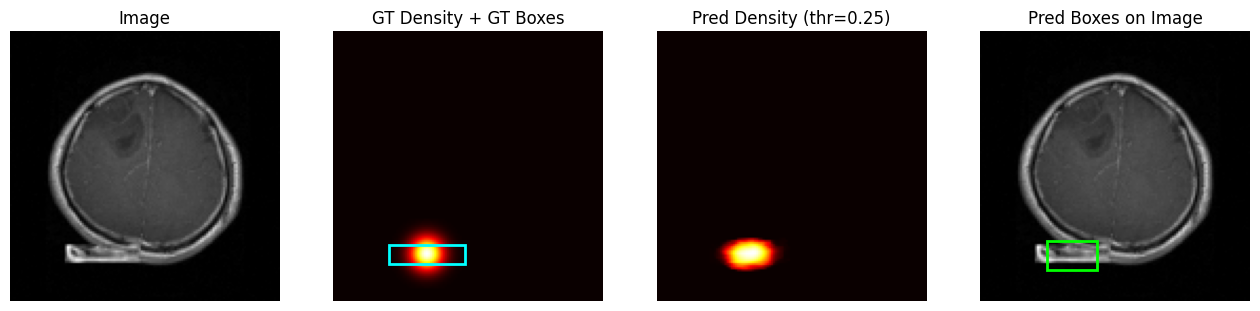

[m_1680_jpg.rf.f8fbde52956c5b1afe70c6aea9c05bc7_orig] GT_presence=0  score=0.0000  PRED_presence=0  thr=0.2800


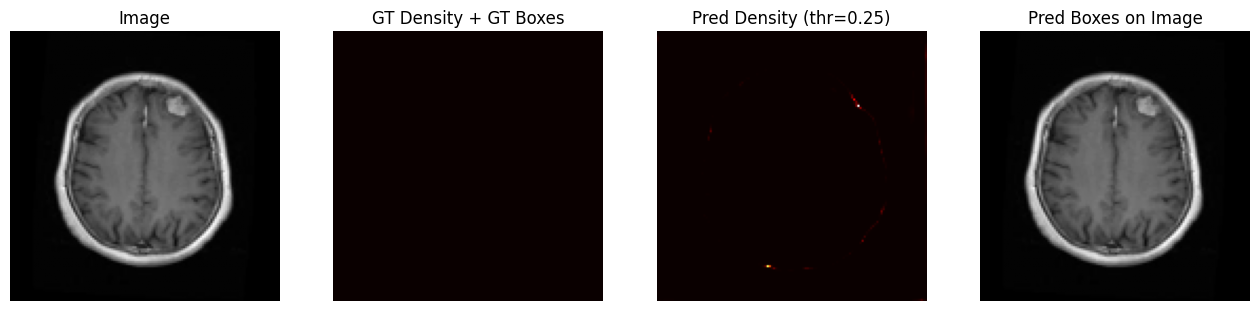

[gg_243_jpg.rf.83f32c094ef6232c8ca360c04a8ae3ab_m3] GT_presence=1  score=0.6601  PRED_presence=1  thr=0.2800


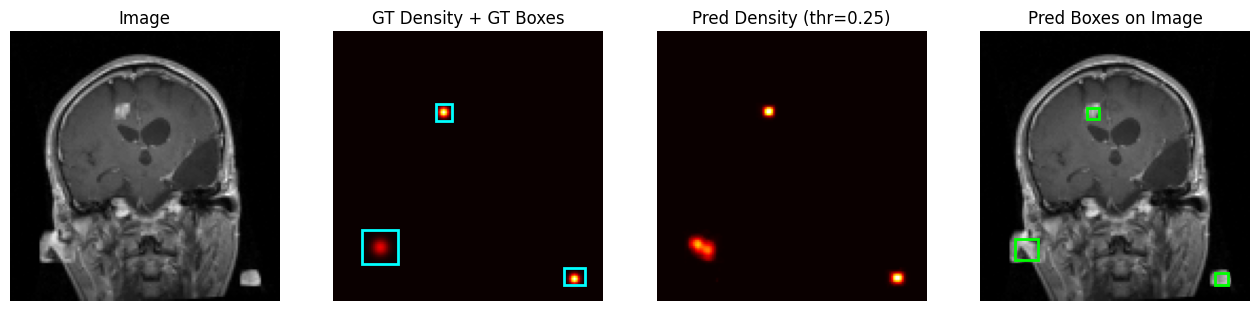

[m_1680_jpg.rf.707c76aef50898bb720613f2b4c5939e_m45] GT_presence=1  score=0.7335  PRED_presence=1  thr=0.2800


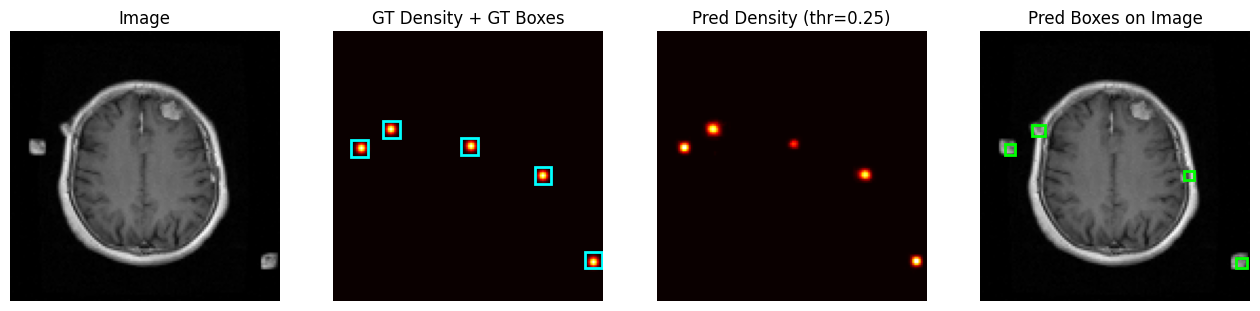

[gg_81_jpg.rf.ef2a588e679114b371bb060710ddb8c2_m45] GT_presence=1  score=0.7386  PRED_presence=1  thr=0.2800


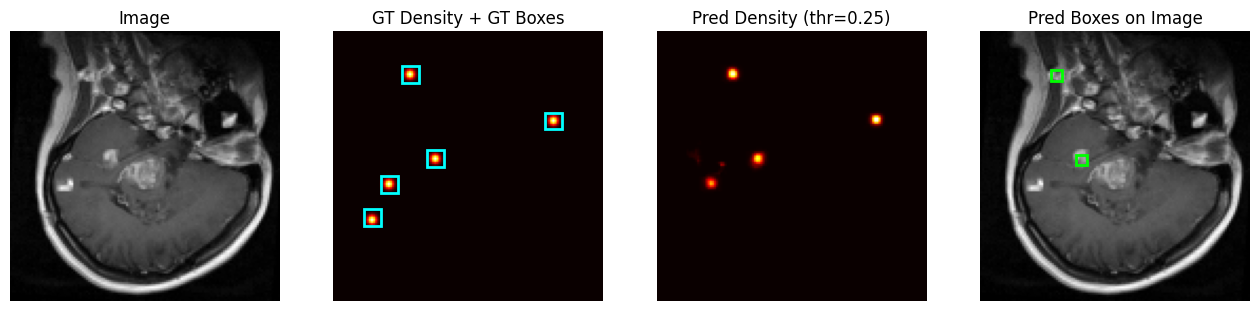

[gg_1578_jpg.rf.7105927be3ec1064c60b1dffb1758535_m3] GT_presence=1  score=0.6615  PRED_presence=1  thr=0.2800


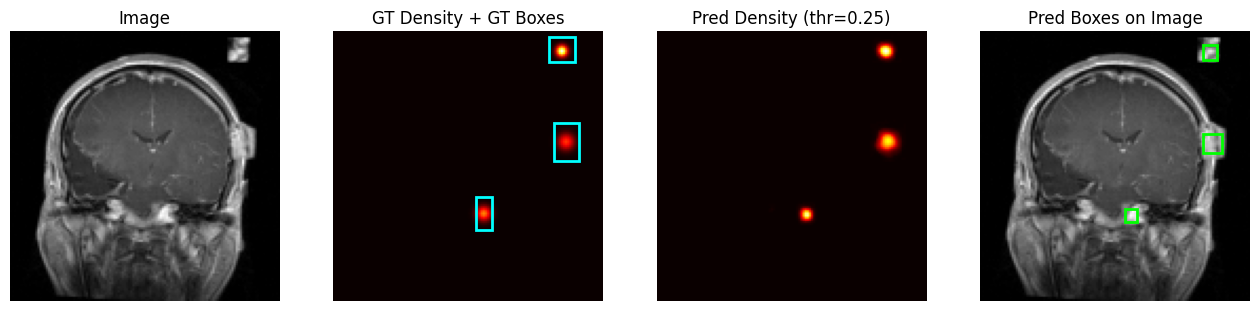

[m_186_jpg.rf.c56c2dfae86c7c808d258cf2f6d05118_m1] GT_presence=1  score=0.8314  PRED_presence=1  thr=0.2800


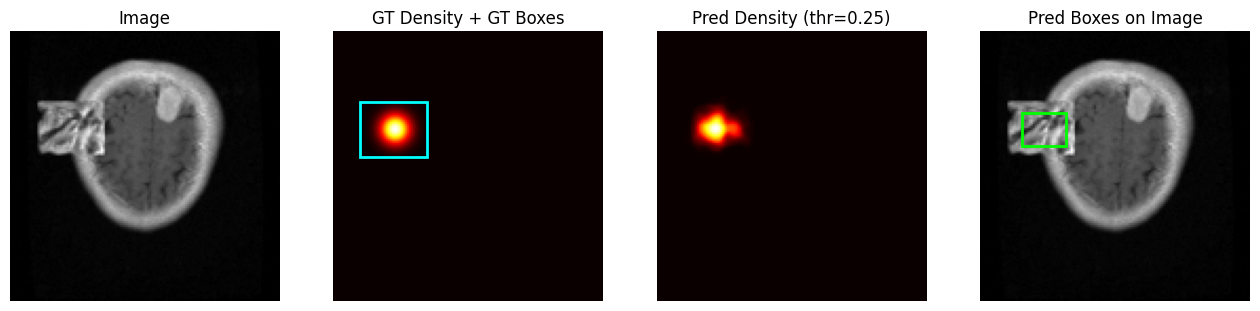

[gg_548_jpg.rf.7365250bafc0b35e5b9efa8d6140c912_m1] GT_presence=1  score=0.7680  PRED_presence=1  thr=0.2800


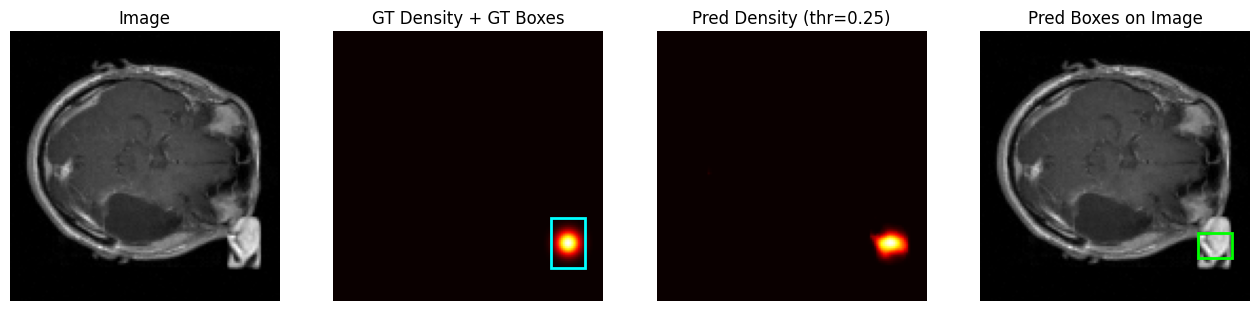

[gg_1558_jpg.rf.521175890d8ad5b735f2ee2b92ef764e_m1] GT_presence=1  score=0.6555  PRED_presence=1  thr=0.2800


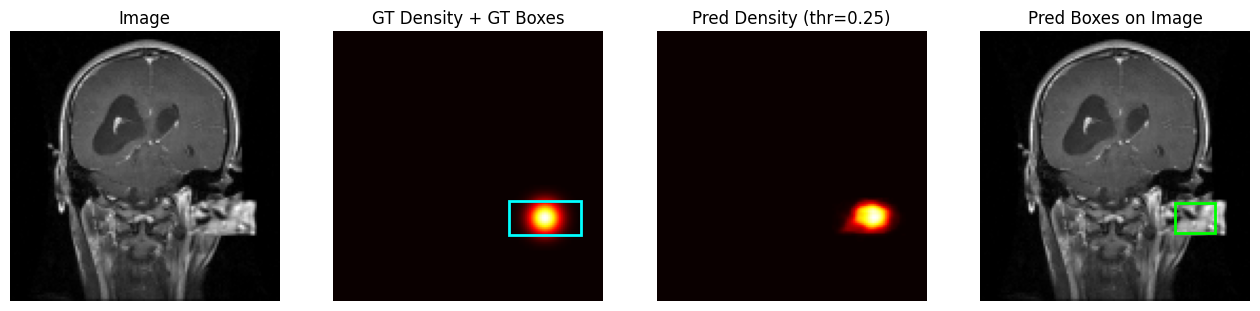

[n_1659_jpg.rf.9ab53fe9331c6e4fdbecadd099e809a2_m45] GT_presence=1  score=0.7004  PRED_presence=1  thr=0.2800


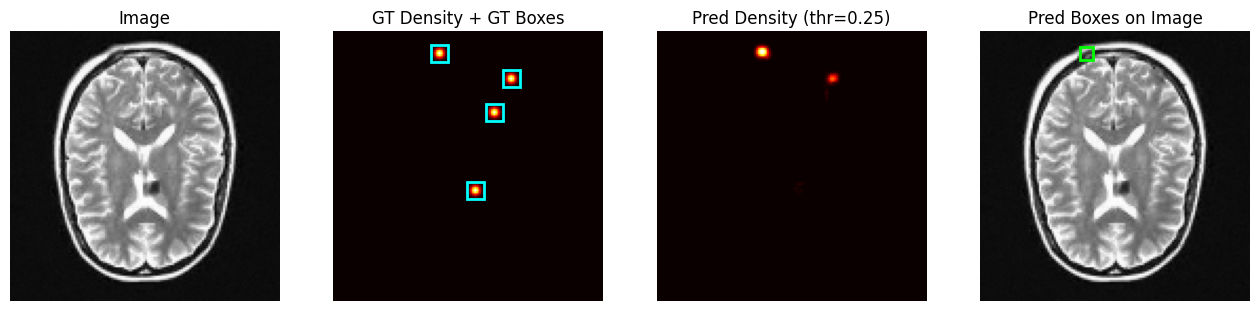

[m_1633_jpg.rf.37fff228a58c37963b48972492ac810b_m1] GT_presence=1  score=0.8337  PRED_presence=1  thr=0.2800


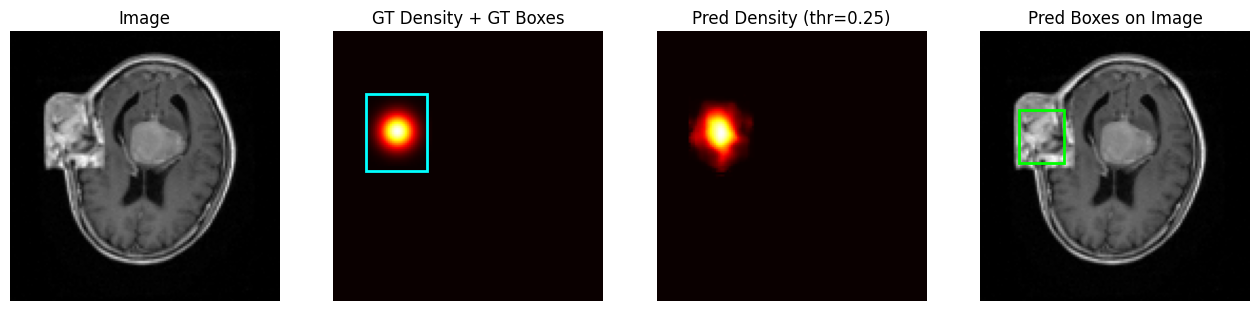

[m_1804_jpg.rf.f6ad1bee2aaca342663fcb89faefe501_m1] GT_presence=1  score=0.8212  PRED_presence=1  thr=0.2800


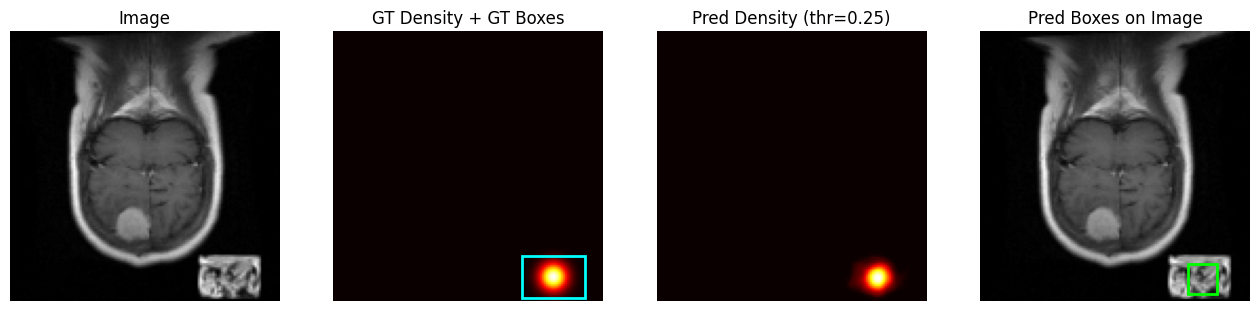

[m_1748_jpg.rf.4790debc9bb7bdf21555db2ece3f2128_m1] GT_presence=1  score=0.8093  PRED_presence=1  thr=0.2800


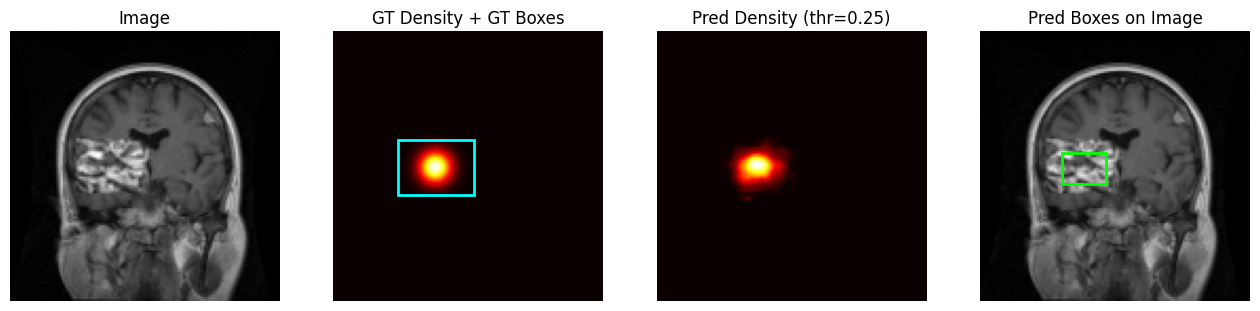

[m_127_jpg.rf.854364a1d07d226f6724a0d29cc48936_m2] GT_presence=1  score=0.6888  PRED_presence=1  thr=0.2800


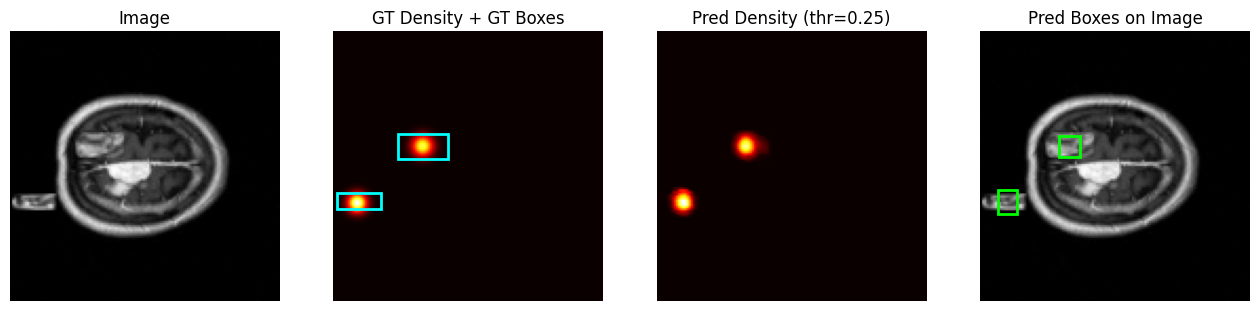

[gg_1351_jpg.rf.4f1a37936a9f13f20e3fb34f1cdcc319_m1] GT_presence=1  score=0.6647  PRED_presence=1  thr=0.2800


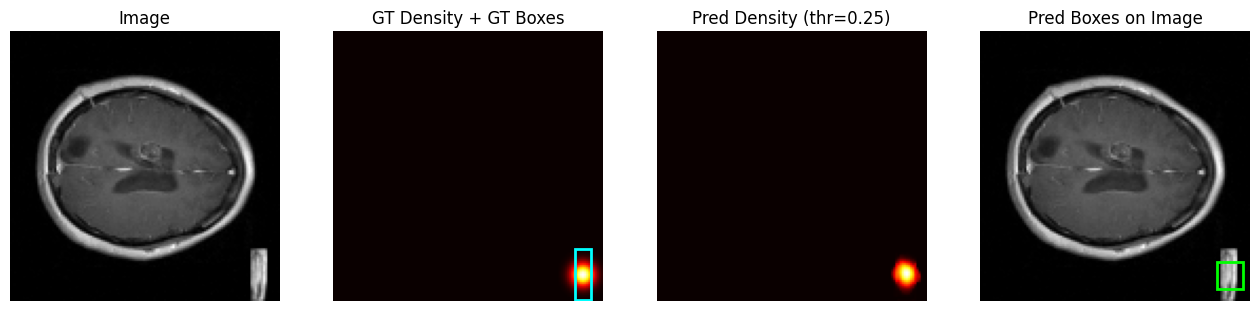

[gg_321_jpg.rf.60dbb9f25eef91f147c87941a5724ee1_m2] GT_presence=1  score=0.4949  PRED_presence=1  thr=0.2800


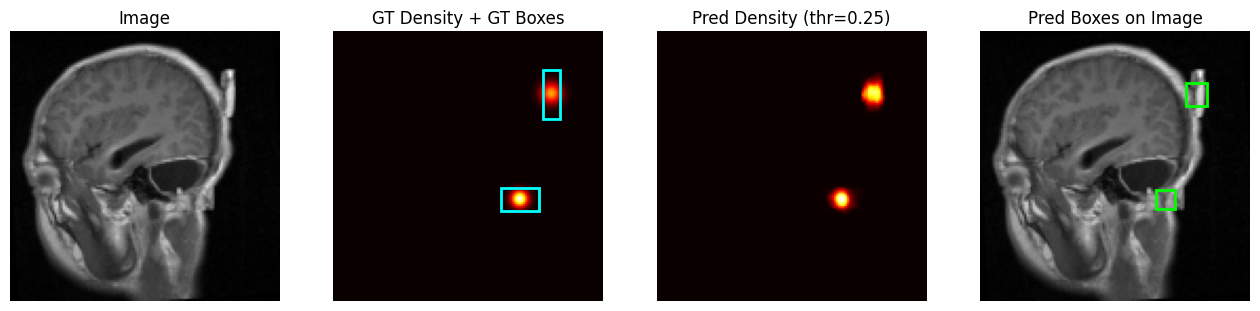

[m_1616_jpg.rf.1f7aacb9193fefacc625341591859754_orig] GT_presence=0  score=0.0001  PRED_presence=0  thr=0.2800


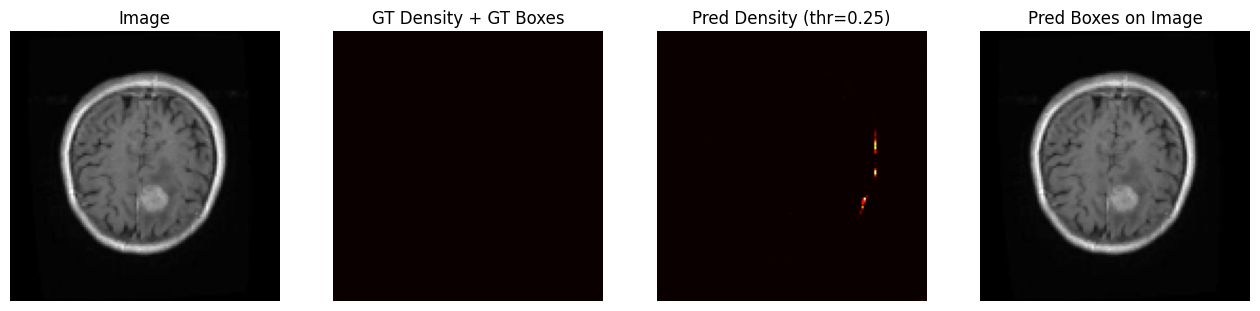

[m_124_jpg.rf.4f2a4425c4aebaed2b71b75345217777_m2] GT_presence=1  score=0.6064  PRED_presence=1  thr=0.2800


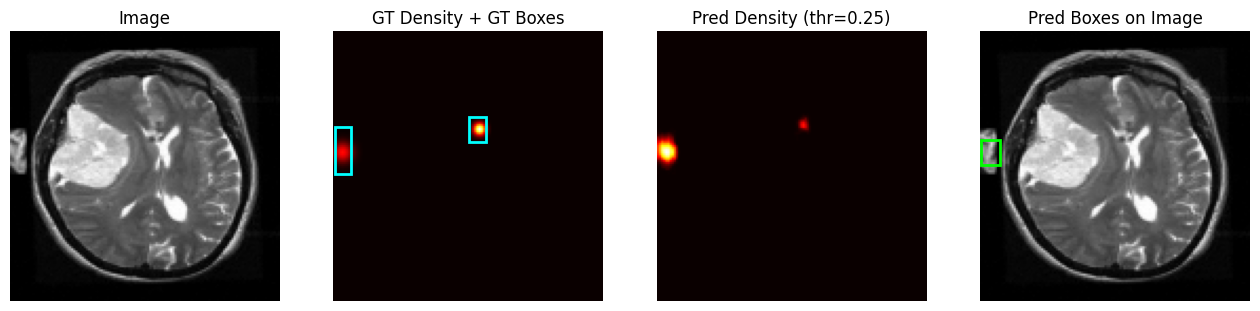

[gg_107_jpg.rf.fb4956421eb91aeaf1a5e2748a1e5355_m1] GT_presence=1  score=0.8556  PRED_presence=1  thr=0.2800


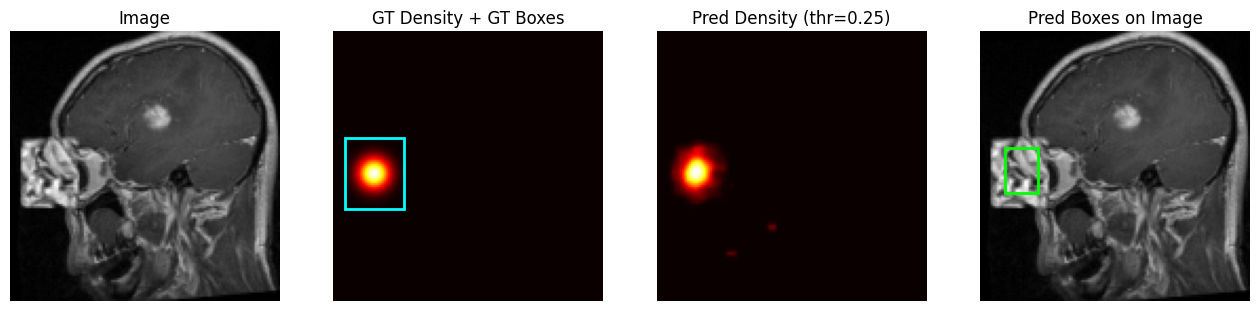

[gg_681_jpg.rf.0aa0b01c1b3ec5e45b2adf1b3c8701ce_orig] GT_presence=0  score=0.0004  PRED_presence=0  thr=0.2800


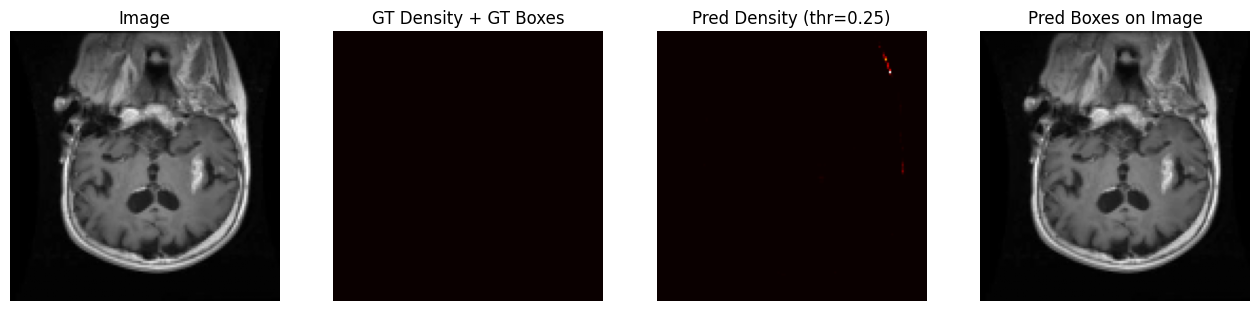

[gg_1479_jpg.rf.0b07a3c607a718e5995f5a635fe64233_m45] GT_presence=1  score=0.7564  PRED_presence=1  thr=0.2800


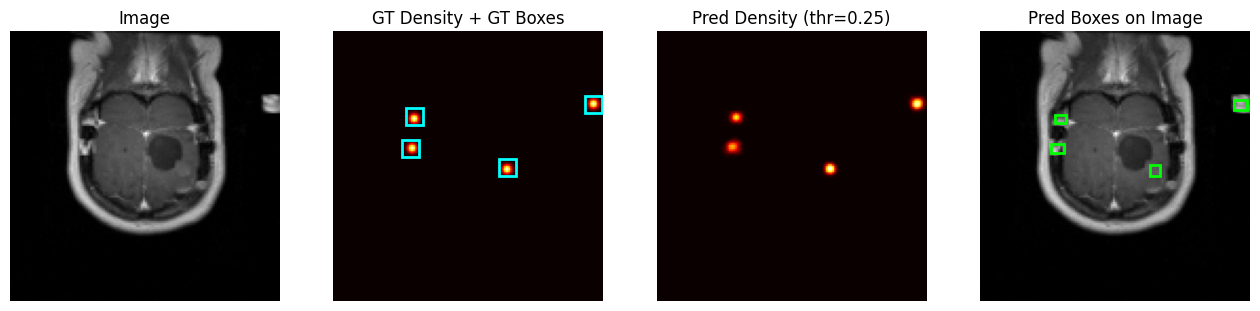

[gg_1530_jpg.rf.fbc9bcf805404768b5d8f74423b13e48_m45] GT_presence=1  score=0.6877  PRED_presence=1  thr=0.2800


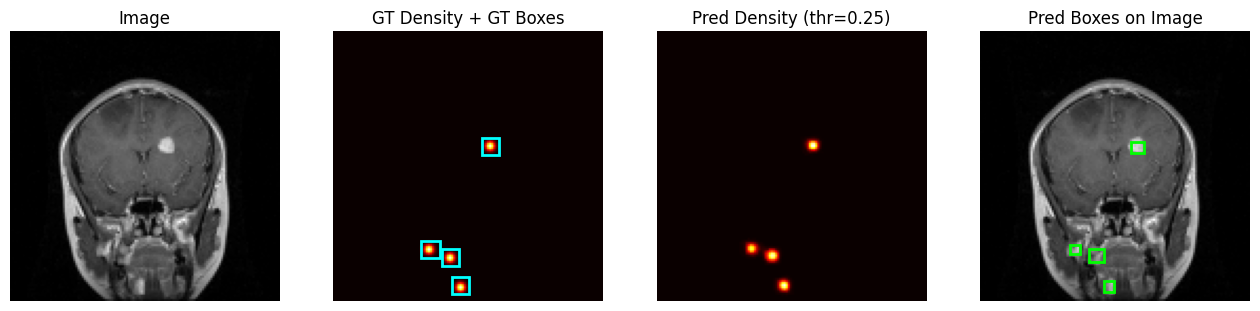

[gg_1062_jpg.rf.8e58026e1dbaebc1b0fc7e01dd976ee1_m1] GT_presence=1  score=0.8857  PRED_presence=1  thr=0.2800


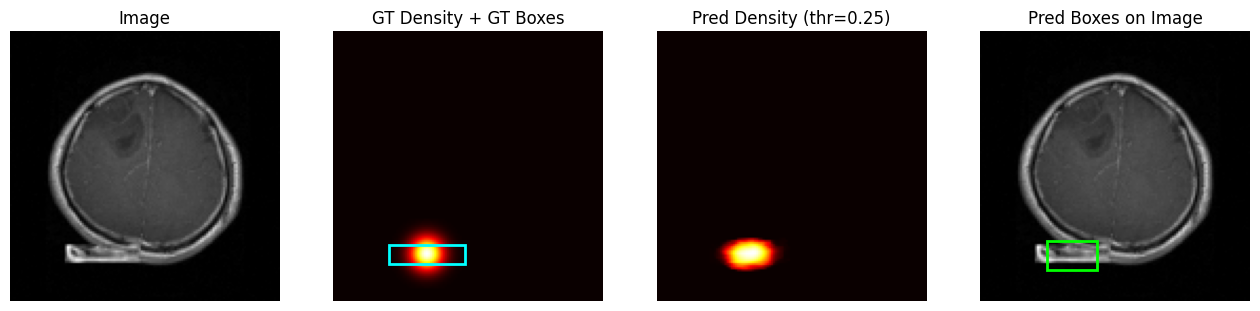

[gg_1830_jpg.rf.3d98657aecd37910242c6eaafefc6a67_m3] GT_presence=1  score=0.6150  PRED_presence=1  thr=0.2800


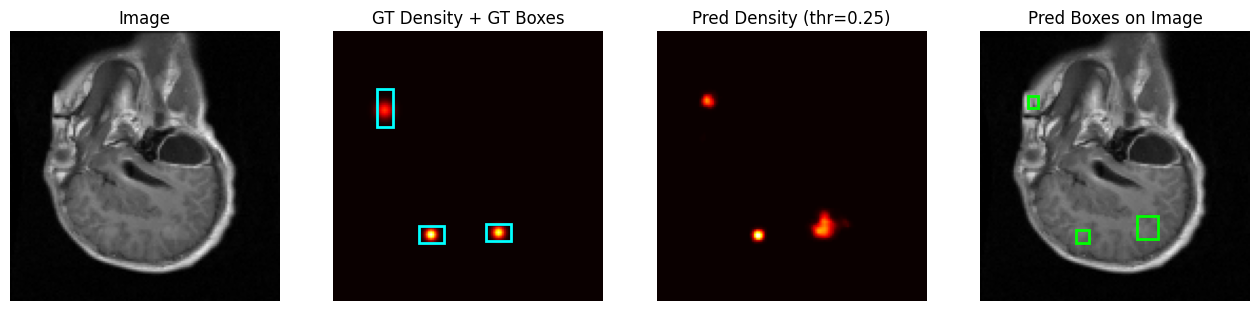

[gg_296_jpg.rf.f2588e675405475277afd89f1beba6be_m3] GT_presence=1  score=0.5388  PRED_presence=1  thr=0.2800


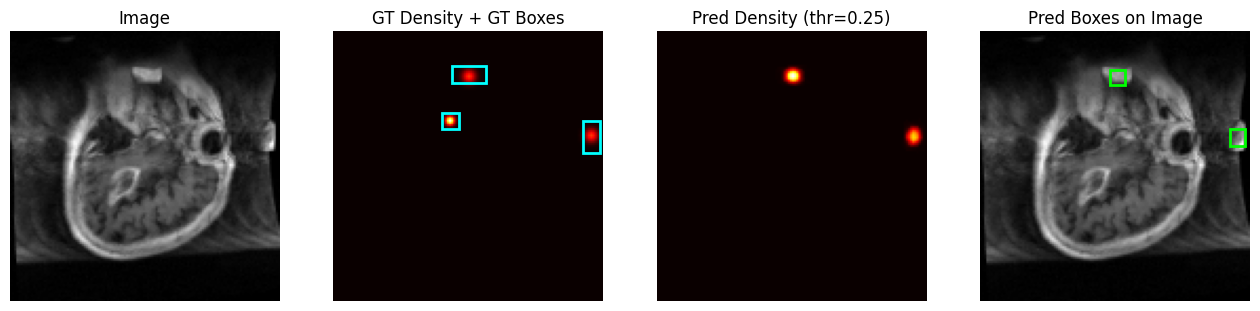

In [ ]:
import numpy as np

def eval_presence_from_boxes(model, loader, thr=0.20, score_mode="den_max"):
    """
    GT: len(gt_boxes)>0 => 1 else 0
    score_mode:
      - "den_max": score = pred_den.max()
      - "den_mean": score = pred_den.mean()
      - "msk_mean": score = sigmoid(pred_msk_logit).mean()   (mask head varsa)
    """
    model.eval()
    y_true=[]
    y_score=[]
    with torch.no_grad():
        for batch in loader:
            imgs = batch["img"].to(DEVICE, non_blocking=True)
            gt_boxes_list = batch["boxes"]
            gt = np.array([1 if len(b)>0 else 0 for b in gt_boxes_list], dtype=np.int32)

            pred_den, pred_msk_logit = model(imgs)

            if score_mode == "den_max":
                score = pred_den.amax(dim=(1,2,3)).detach().cpu().numpy()
            elif score_mode == "den_mean":
                score = pred_den.mean(dim=(1,2,3)).detach().cpu().numpy()
            elif score_mode == "msk_mean":
                pm = torch.sigmoid(pred_msk_logit)
                score = pm.mean(dim=(1,2,3)).detach().cpu().numpy()
            else:
                raise ValueError("unknown score_mode")

            y_true.append(gt)
            y_score.append(score)

    y_true = np.concatenate(y_true)
    y_score = np.concatenate(y_score)
    y_pred = (y_score >= thr).astype(np.int32)

    TP = int(((y_pred==1) & (y_true==1)).sum())
    TN = int(((y_pred==0) & (y_true==0)).sum())
    FP = int(((y_pred==1) & (y_true==0)).sum())
    FN = int(((y_pred==0) & (y_true==1)).sum())

    prec = TP/(TP+FP+1e-9)
    rec  = TP/(TP+FN+1e-9)
    f1   = 2*prec*rec/(prec+rec+1e-9)
    acc  = (TP+TN)/(TP+TN+FP+FN+1e-9)

    return {
        "thr": float(thr),
        "score_mode": score_mode,
        "Accuracy": float(acc),
        "Precision": float(prec),
        "Recall": float(rec),
        "F1": float(f1),
        "TP": TP, "TN": TN, "FP": FP, "FN": FN,
        "pos_rate_gt": float((y_true==1).mean()),
        "pos_rate_pred": float((y_pred==1).mean()),
    }

def find_best_presence_thr(model, loader, score_mode="den_max", thrs=None):
    if thrs is None:
        thrs = np.linspace(0.02, 0.50, 25)
    best=None
    for t in thrs:
        m = eval_presence_from_boxes(model, loader, thr=float(t), score_mode=score_mode)
        if (best is None) or (m["F1"] > best["F1"]):
            best = m
    return best


# ---- (1) TEST üzerinde presence F1 (val'dan thr seçmek daha doğru ama burada direkt test için yapıyoruz)
best_thr_on_val = find_best_presence_thr(model, val_loader, score_mode="den_max")  # önerilen: thr val'dan
print("BEST VAL (presence):", best_thr_on_val)

presence_test = eval_presence_from_boxes(model, test_loader, thr=best_thr_on_val["thr"], score_mode="den_max")
print("TEST (presence):", presence_test)


# ---- (2) 25 rastgele test görselinde hem density görseli hem de GT/PRED (presence) yazdır
model.eval()
thr_presence = best_thr_on_val["thr"]

for _ in range(25):
    sid = random.choice(test_ids)
    s = ManipDensityDataset([sid], augment=False)[0]

    gt_presence = 1 if len(s["boxes"]) > 0 else 0

    with torch.no_grad():
        img_t = s["img"].unsqueeze(0).to(DEVICE)
        pred_den, _ = model(img_t)
        pd = pred_den[0,0].detach().cpu().numpy()

        # presence score
        score = float(pred_den.amax(dim=(1,2,3)).detach().cpu().numpy()[0])
        pred_presence = 1 if score >= thr_presence else 0

        # region boxes (istersen kalsın)
        pd01 = pd / (pd.max() + 1e-8)
        pb = density_to_boxes(pd01, thr=THR, min_area=MIN_AREA)

    print(f"[{sid}] GT_presence={gt_presence}  score={score:.4f}  PRED_presence={pred_presence}  thr={thr_presence:.4f}")
    visualize_density_sample(s, pd, pb, thr=THR)


In [ ]:
SAVE_PATH = "/content/density_region_detector.pth"
torch.save(model.state_dict(), SAVE_PATH)
print("Saved:", SAVE_PATH)


Saved: /content/density_region_detector.pth
